# Complete experiment to try to estimate the probability of an offer to "succeed" with one customer. The "informative" offers are considered successful if the customer views them. Other kinds of offers are successful only if the customer views them, and then completes them.

Table of contents <a id='top'>

1. [Get the data and show it](#data)
2. [Create the Model](#model)
3. [Evaluate the Model](#eval)
4. [Analysis and Conclusions](#conclusions)
5. [Test Results](#test)

In [31]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.pipeline import Pipeline
import datetime as dt
from xgboost import XGBClassifier

ROOT_DIR = '../..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')
SRC = os.path.join(ROOT_DIR, 'src')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp
import src.data.success_dataset as sd
import src.data.missing_data as md
import src.evaluation.offer_success as evos
import src.visualization.visualize as vis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Get the data and show it <a id='data'/>
[Top](#top)

In [32]:
# Get the data
STATIC_DATASET_PATH = os.path.join(DATA_PROCESSED, 'static_cluster1.pkl')

X_train_val, X_test, y_train_val, y_test, encoder = sd.get_success_data(
    basic_dataset_path=STATIC_DATASET_PATH,
    drop_time=False)

# Time-split validation datasets
X_test = sd.drop_time_dependent(X_test)
X_train, X_val, y_train, y_val = sd.time_split(X_train_val, 
                                               y_train_val,
                                               time_limit=370)

In [33]:
print(X_train.shape)
print(y_train.shape)
X_train.head()

(38030, 16)
(38030,)


,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,channel_email,channel_social,channel_mobile,kmeans_8,ward_12,dbscan_10
0,33.0,M,72000.0,0,17277,0.0,3.0,informational,0.0,0.0,1.0,1.0,1.0,0.0,8.0,1.0
1,33.0,M,72000.0,0,17277,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0,0.0,8.0,1.0
5,NaN,None,NaN,1,17646,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
7,40.0,O,57000.0,0,17540,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0,0.0,9.0,-1.0
8,40.0,O,57000.0,0,17540,7.0,7.0,discount,3.0,1.0,1.0,1.0,1.0,0.0,9.0,-1.0


In [34]:
print(X_val.shape)
print(y_val.shape)
X_val.head()

(12778, 16)
(12778,)


,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,channel_email,channel_social,channel_mobile,kmeans_8,ward_12,dbscan_10
2,33.0,M,72000.0,0,17277,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,0.0,8.0,1.0
10,40.0,O,57000.0,0,17540,20.0,10.0,discount,5.0,1.0,1.0,0.0,0.0,0.0,9.0,-1.0
15,59.0,F,90000.0,0,16864,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0
19,24.0,F,60000.0,0,17116,0.0,3.0,informational,0.0,0.0,1.0,1.0,1.0,6.0,1.0,-1.0
24,26.0,F,73000.0,0,17338,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,6.0,1.0,-1.0


In [35]:
print(X_test.shape)
print(y_test.shape)
X_test.head()

(25469, 16)
(25469,)


,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,channel_email,channel_social,channel_mobile,kmeans_8,ward_12,dbscan_10
3,33.0,M,72000.0,0,17277,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,0.0,8.0,1.0
4,33.0,M,72000.0,0,17277,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,0.0,8.0,1.0
6,NaN,None,NaN,1,17646,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
11,40.0,O,57000.0,0,17540,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,0.0,9.0,-1.0
16,59.0,F,90000.0,0,16864,0.0,3.0,informational,0.0,0.0,1.0,1.0,1.0,4.0,4.0,0.0


## 2. Create the model <a id='model'/>
[Top](#top)

In [36]:
model = Pipeline([
    ('encoder', pp.BasicEncoder()),
    ('imputer', md.BasicImputer(fill_mode=['kmeans_8', 'ward_12', 'dbscan_10'])),
    ('estimator', XGBClassifier(max_depth=7, n_estimators=200, n_jobs=-1,
                                random_state=2018))
])

## 3. Evaluate the model <a id='eval'/>
[Top](#top)

### Time-split Validation

In [44]:
trained_model, y_train_pred, y_val_pred = evos.time_split_validation(model, 
                                                                     basic_dataset_path=STATIC_DATASET_PATH)

Training time: 9.339598417282104 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[16193  3939]
 [ 4315 13583]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.80     20132
           1       0.78      0.76      0.77     17898

   micro avg       0.78      0.78      0.78     38030
   macro avg       0.78      0.78      0.78     38030
weighted avg       0.78      0.78      0.78     38030

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[4958 1785]
 [1972 4063]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.74      0.73      6743
           1       0.69      0.67      0.68      6035

   micro avg       0.71

### Customer-split validation

In [46]:
evos.random_1fold_cust_validation(model, basic_dataset_path=STATIC_DATASET_PATH)

Training time: 6.74726676940918 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[15097  3623]
 [ 3924 12813]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80     18720
           1       0.78      0.77      0.77     16737

   micro avg       0.79      0.79      0.79     35457
   macro avg       0.79      0.79      0.79     35457
weighted avg       0.79      0.79      0.79     35457

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[5966 2189]
 [2375 4821]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.73      0.72      8155
           1       0.69      0.67      0.68      7196

   micro avg       0.70 

## 4. Analysis and Conclusions <a id='conclusions'/>
[Top](#top)

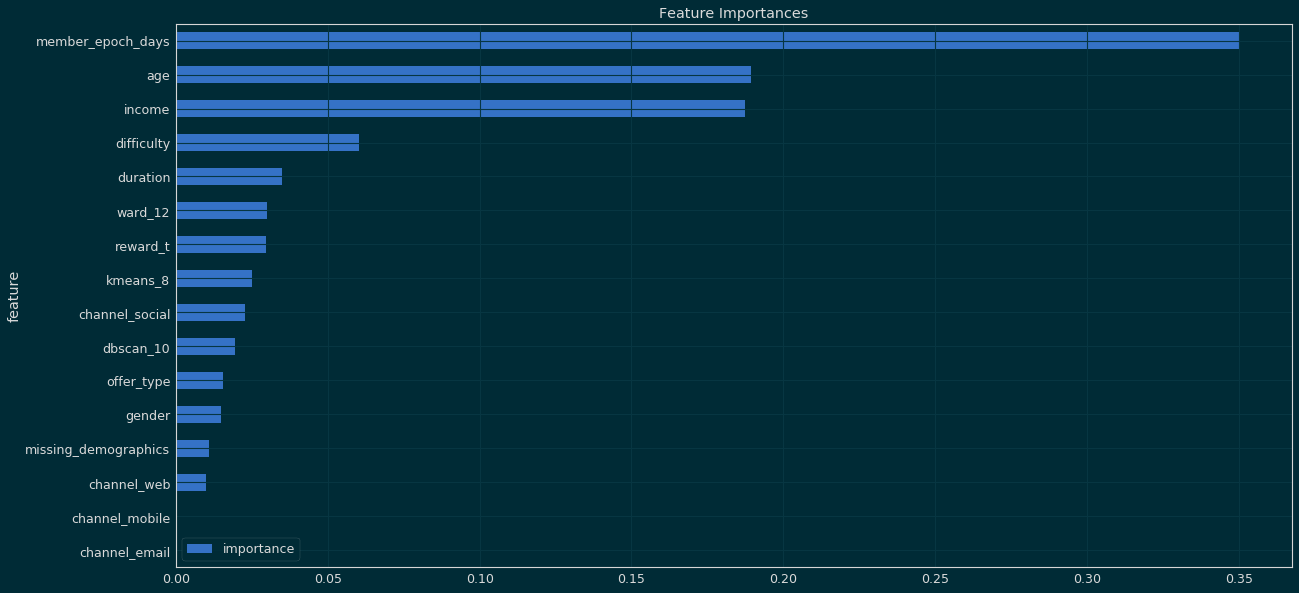

<Figure size 1440x720 with 0 Axes>

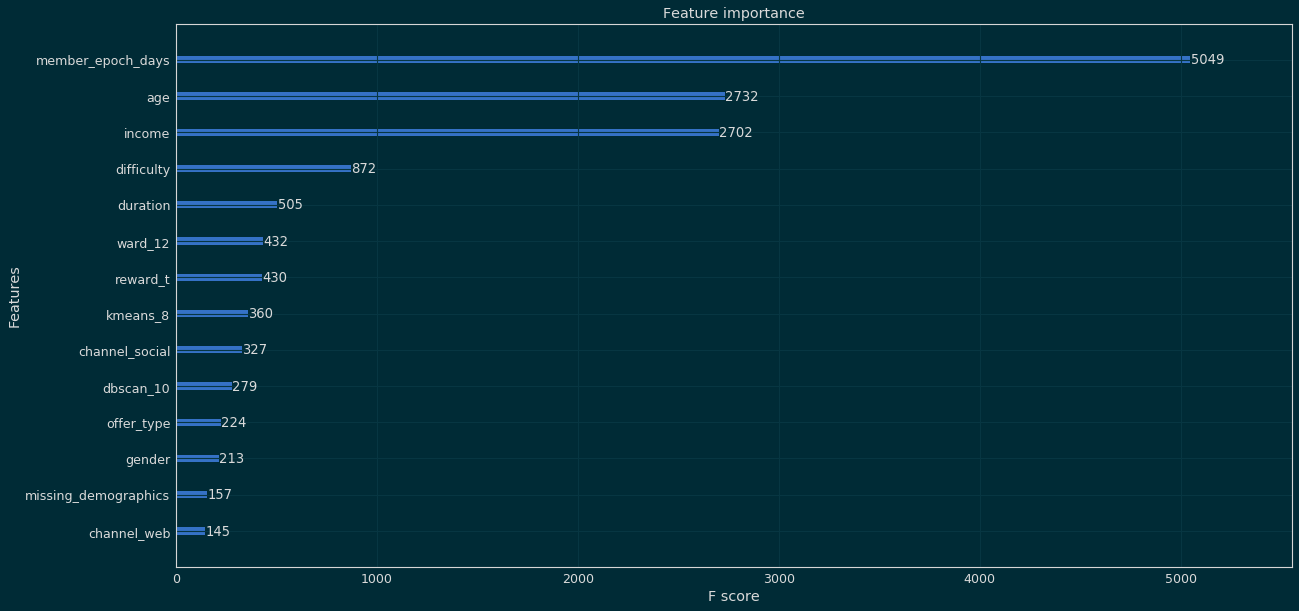

In [47]:
vis.show_feat_importances(model, X_train)

## 5. Test Results (only run this once, after adjusting all the hyperparameters) <a id='test'/>
[Top](#top)

In [49]:
evos.offer_success_test(model, basic_dataset_path=STATIC_DATASET_PATH)

Training time: 9.557669162750244 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[21410  5465]
 [ 6197 17736]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79     26875
           1       0.76      0.74      0.75     23933

   micro avg       0.77      0.77      0.77     50808
   macro avg       0.77      0.77      0.77     50808
weighted avg       0.77      0.77      0.77     50808

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[10262  3726]
 [ 3498  7983]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74     13988
           1       0.68      0.70      0.69     11481

   micro avg       